In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

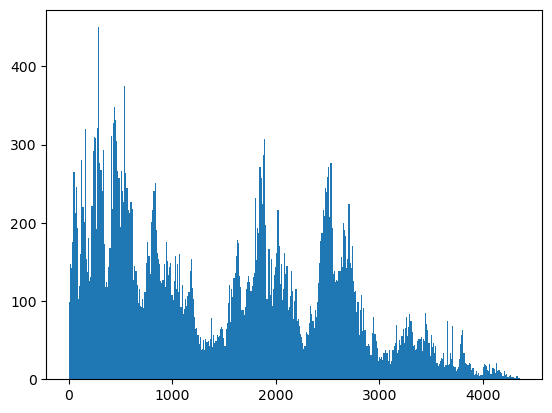

In [3]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('D:/data/Zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 400)

In [21]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [8]:
zircons_data = data[0]
ages = data[1][1:]

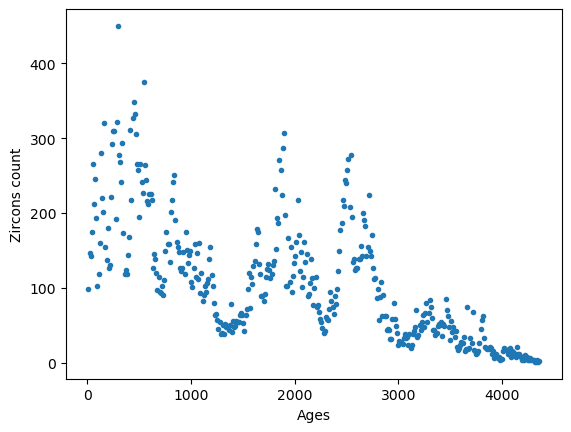

In [10]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [12]:
ages_nominal = np.arange(len(ages))

In [15]:
with pm.Model() as zircons_model:
    
    k = 4
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    
    switchpoint1 = pm.DiscreteUniform("switchpoint1", lower=ages_nominal.min(), upper=ages_nominal.max()-3)
    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    switchpoint2 = pm.DiscreteUniform("switchpoint2", lower=switchpoint1+1, upper=ages_nominal.max()-2)
    switchpoint3 = pm.DiscreteUniform("switchpoint3", lower=switchpoint2+1, upper=ages_nominal.max()-1)
    switchpoint4 = pm.DiscreteUniform("switchpoint4", lower=switchpoint3+1, upper=ages_nominal.max())
    switchpoints = [switchpoint1,switchpoint2,switchpoint3,switchpoint4]
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)
    rates = pm.Exponential("rates",1.0,shape = k+1)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [16]:
with zircons_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint1]
>>Metropolis: [switchpoint2]
>>Metropolis: [switchpoint3]
>>Metropolis: [switchpoint4]
>NUTS: [rates]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


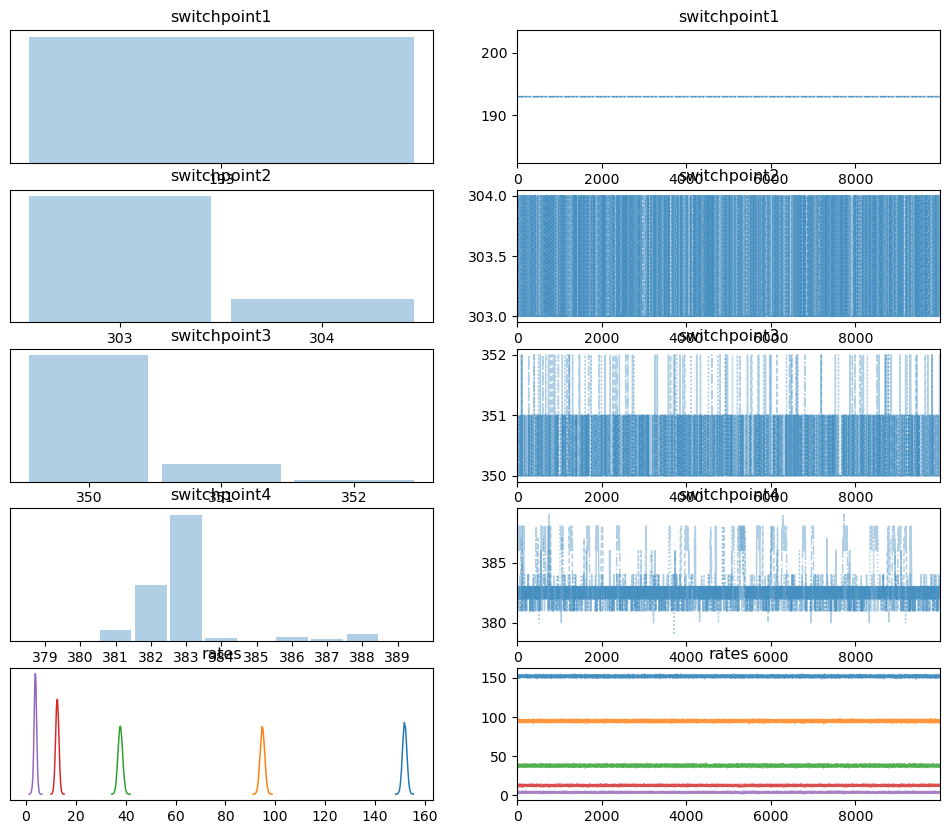

In [17]:
az.plot_trace(idata,combined=True);

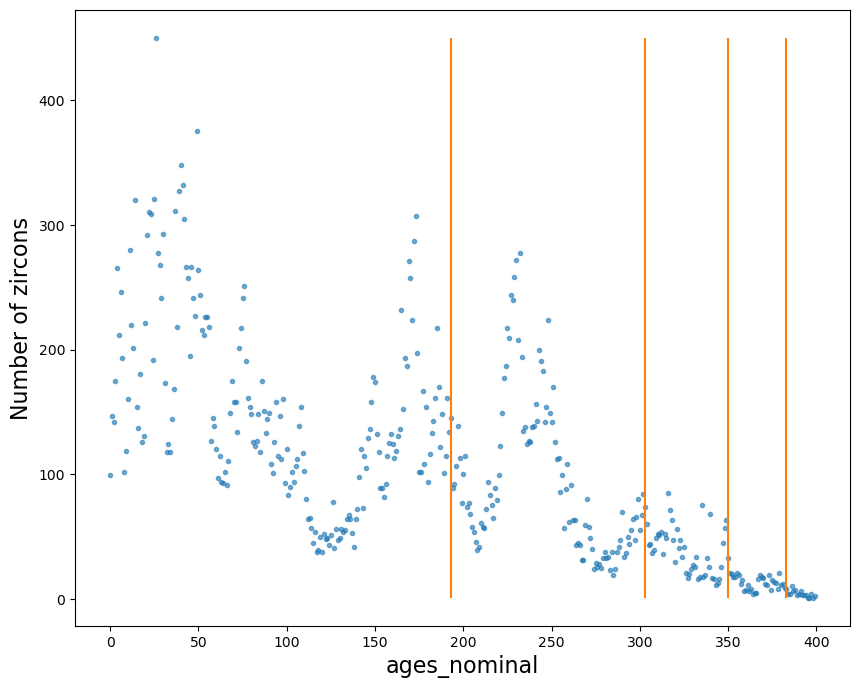

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(ages_nominal, zircons_data, ".", alpha=0.6)
plt.ylabel("Number of zircons", fontsize=16)
plt.xlabel("ages_nominal", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint1"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
plt.vlines(trace["switchpoint2"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
plt.vlines(trace["switchpoint3"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
plt.vlines(trace["switchpoint4"].mean(), zircons_data.min(), zircons_data.max(), color="C1")

In [19]:
az.summary(idata, round_to=2)

E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint1,193.00,0.00,193.00,193.00,0.00,0.00,40000.00,40000.00,NaN
switchpoint2,303.15,0.36,303.00,304.00,0.00,0.00,6292.72,6292.72,1.0
switchpoint3,350.14,0.38,350.00,351.00,0.01,0.00,5406.18,5684.31,1.0
switchpoint4,382.92,1.32,381.00,386.00,0.05,0.04,1254.33,621.75,1.0
rates[0],151.94,0.88,150.26,153.57,0.00,0.00,58176.81,33481.53,1.0
rates[1],94.85,0.93,93.06,96.58,0.00,0.00,59341.76,33394.42,1.0
rates[2],37.84,0.92,36.14,39.58,0.00,0.00,39817.88,30668.58,1.0
rates[3],12.52,0.66,11.31,13.78,0.01,0.01,5577.92,5656.90,1.0
rates[4],3.74,0.54,2.74,4.80,0.01,0.01,2979.69,1575.05,1.0
